# Importing libraries



In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard
import os
import tempfile
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

NAME = "Deliquents-vs-LawOfficers-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/CNN model/{}'.format(NAME))
tensorboardOf = TensorBoard(log_dir='logs/CNN with Over-fitting and Regularization model/{}'.format(NAME))
tensorboardRr = TensorBoard(log_dir='logs/CNN with Ridge Regression Regularization model/{}'.format(NAME))

### Importing and showing the deployed dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Rodrigo190119/TDP-Surveillance_Prediction_Model/main/Dataset.csv")
df.head()

,Person_type,Colour,Height,Age,Gender,Head,Torso,Legs,Feet,Accessories,Blood,Armed,Banners,Type,x_min,y_min,x_max,y_max,Actions
0,Law Officer,Native,1.80,32,M,Cap|face mask,Jacket,N.I,N.I,None,No,Gun,None,Seated,51,6,392,705,5
1,Delinquent,White,1.73,21,M,None|face mask,T-shirt,N.I,N.I,None,No,No,None,Moving,426,92,623,718,5
2,Law Officer,Native,1.72,44,M,Cap|face mask,Shirt,N.I,N.I,None,No,Gun,None,Moving,646,129,926,720,5
3,Law Officer,White,1.73,55,M,Face mask,T-shirt,N.I,N.I,None,No,No,None,Standing,316,83,646,720,5
4,Viewer,White,1.75,57,M,Face mask,T-shirt,N.I,N.I,None,No,No,None,Standing,699,69,1095,720,5


### Preparing the Dataset

In this section, we must choose the columns that will be used to train the predictive model and get rid of the ones that are not. In this case, we will use the columns of information collected manually such as "Person_type", "Armed" and "Actions"

In [3]:
cols_to_drop = ['Colour', 'Height', 'Age', 'Gender', 'Head', 'Torso', 'Legs', 'Feet', 'Accessories', 'Blood', 'Banners', 'Type', 'x_min', 'y_min', 'x_max', 'y_max']
df = df.drop(cols_to_drop, axis = 1)
df.head()

,Person_type,Armed,Actions
0,Law Officer,Gun,5
1,Delinquent,No,5
2,Law Officer,Gun,5
3,Law Officer,No,5
4,Viewer,No,5


Next, data used in the predictive model needs to be numerical. We can see that the columns "Person_type" and "Armed" contain classified values. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Person_type  1610 non-null   object
 1   Armed        1610 non-null   object
 2   Actions      1610 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 37.9+ KB


To adapt the data to the model we need, each column value is added as new columns and binary values are assigned to them. 

In [5]:
Person_TypeColumnDummy = pd.get_dummies(df['Person_type'])
Armed_TypeColumnDummy = pd.get_dummies(df['Armed'])
df = pd.concat((df, Person_TypeColumnDummy, Armed_TypeColumnDummy), axis=1)
df.head()

,Person_type,Armed,Actions,Aggressor,Delinquent,Law Officer,Victim,Viewer,Gun,Knife,No,Other
0,Law Officer,Gun,5,0,0,1,0,0,1,0,0,0
1,Delinquent,No,5,0,1,0,0,0,0,0,1,0
2,Law Officer,Gun,5,0,0,1,0,0,1,0,0,0
3,Law Officer,No,5,0,0,1,0,0,0,0,1,0
4,Viewer,No,5,0,0,0,0,1,0,0,1,0


Then, original columns are removed.

In [6]:
df = df.drop(['Person_type', 'Armed'], axis=1)
df.head()

,Actions,Aggressor,Delinquent,Law Officer,Victim,Viewer,Gun,Knife,No,Other
0,5,0,0,1,0,0,1,0,0,0
1,5,0,1,0,0,0,0,0,1,0
2,5,0,0,1,0,0,1,0,0,0
3,5,0,0,1,0,0,0,0,1,0
4,5,0,0,0,0,1,0,0,1,0


The training exercise consists of predicting if a person is considered as delinquent analizing their actions and if they possess a weapon. To quickly assign the columns to be used for training, the columns referring to the type of person should be placed at the end. 

In [7]:
c1 = df.pop('Gun')
c2 = df.pop('Knife')
c3 = df.pop('No')
c4 = df.pop('Other')
df.insert(1, 'Gun', c1)
df.insert(1, 'Knife', c2)
df.insert(1, 'No', c3)
df.insert(1, 'Other', c4)
df.head()

,Actions,Other,No,Knife,Gun,Aggressor,Delinquent,Law Officer,Victim,Viewer
0,5,0,0,0,1,0,0,1,0,0
1,5,0,1,0,0,0,1,0,0,0
2,5,0,0,0,1,0,0,1,0,0
3,5,0,1,0,0,0,0,1,0,0
4,5,0,1,0,0,0,0,0,0,1


We confirm that the data in the dataset has purely numeric values.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Actions      1610 non-null   int64
 1   Other        1610 non-null   uint8
 2   No           1610 non-null   uint8
 3   Knife        1610 non-null   uint8
 4   Gun          1610 non-null   uint8
 5   Aggressor    1610 non-null   uint8
 6   Delinquent   1610 non-null   uint8
 7   Law Officer  1610 non-null   uint8
 8   Victim       1610 non-null   uint8
 9   Viewer       1610 non-null   uint8
dtypes: int64(1), uint8(9)
memory usage: 26.9 KB


To analize the dataset this is converted into an array

In [9]:
dataset = df.values

In [10]:
dataset

array([[ 5,  0,  0, ...,  1,  0,  0],
       [ 5,  0,  1, ...,  0,  0,  0],
       [ 5,  0,  0, ...,  1,  0,  0],
       ...,
       [12,  0,  1, ...,  0,  0,  1],
       [12,  0,  1, ...,  0,  0,  1],
       [12,  0,  1, ...,  0,  0,  1]], dtype=int64)

Here we define the metrics of the coordinate axes. Notice that the all rows in the dataset are asigned to "X", but we only extract the first 5 columns since those are the columns that are being analized in the future. Then, the column "Delinquent" of the excersise is asigned to the Y axis.

In [11]:
X = dataset[: ,0:5]
Y = dataset[: ,6]

 We scale the data using packages from scikit-learn. The min_max_scaler function scales the dataset so the input features are between 0 and 1.

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [13]:
X_scale

array([[0.35714286, 0.        , 0.        , 0.        , 1.        ],
       [0.35714286, 0.        , 1.        , 0.        , 0.        ],
       [0.35714286, 0.        , 0.        , 0.        , 1.        ],
       ...,
       [0.85714286, 0.        , 1.        , 0.        , 0.        ],
       [0.85714286, 0.        , 1.        , 0.        , 0.        ],
       [0.85714286, 0.        , 1.        , 0.        , 0.        ]])

We split the dataset into a test set, validation set and training set. The size of the validation and test will be 30% of the dataset. Then, we split again the validation set and test set so they have the same size.

Now, we have six variables that will be used in the dataset:


*   X_train (70% of dataset, 5 input features)
*   X_val (15% of dataset, 5 input features)
*   X_test (15% of dataset, 5 input features)
*   Y_train (70% of dataset, 1 label features)
*   Y_val (15% of dataset, 1 label features)
*   Y_test (15% of dataset, 1 label features)

In [14]:
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X_scale, Y, test_size=0.3)

In [15]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5)

This shows the shapes of the arrays (i.e. their dimensions)

In [16]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(1127, 5) (241, 5) (242, 5) (1127,) (241,) (242,)


The training set has 1127 data points, the validation set has 241 data points and the test set has 242 data points. This is because the amount of data in the dataset is odd. The X variables have 5 input features, while the Y variables has one feature (the one to predict).


### Building and Training the Neural Network

### CNN

#### Setting up the Architecture

In [17]:
model = Sequential([ #the model will be stored in the variable and it will be described sequentially
    Dense(32, activation='relu', input_shape=(5,)), #first dense layer with 32 neurons, RelU activation and 5 inputs
    Dense(32, activation='relu'), #second dense layer with 32 neurons and RelU activation
    Dense(1, activation='sigmoid'), #third dense layer with 1 neuron and sigmoid activation 
])

#### Choosing algorithm, loss function and metrics

We call the function "model.compile" to configure the model.

In [18]:
model.compile(optimizer='sgd', #using Stochastic Gradient Descent algorithm
              loss='binary_crossentropy', #loss function for outputs (takes values 1 or 0)
              metrics=['accuracy']) #tracks the accuracy

The "fit" function sets the parameters to the data. We are using the X_train and Y_train data. The size of the batch is 32 and how long we want to train setting the value of "epochs". The validation data is specified so the model will tell us how we are doing on the validation at each point. This function returns a history wich we are saving as the variable "h".

In [19]:
h = model.fit(X_train, Y_train,
          batch_size=32, epochs=100,  
          validation_data=(X_val, Y_val),callbacks=[tensorboard])

Epoch 1/100
 1/36 [..............................] - ETA: 0s - loss: 0.7030 - accuracy: 0.4062WARNING:tensorflow:From C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
36/36 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.7640 - val_loss: 0.5939 - val_accuracy: 0.8714
Epoch 2/100
36/36 [==============================] - 0s 665us/step - loss: 0.5567 - accuracy: 0.8713 - val_loss: 0.5192 - val_accuracy: 0.8714
Epoch 3/100
36/36 [==============================] - 0s 665us/step - loss: 0.4932 - accuracy: 0.8713 - val_loss: 0.4713 - val_accuracy: 0.8714
Epoch 4/100
36/36 [==============================] - 0s 637us/step - loss: 0.4528 - accuracy: 0.8713 - val_loss: 0.4374 - val_accuracy: 0.8714
Epoch 5/100
36/36 [==============================] - 0s 639us/step 

36/36 [==============================] - 0s 656us/step - loss: 0.3700 - accuracy: 0.8713 - val_loss: 0.3751 - val_accuracy: 0.8714
Epoch 55/100
36/36 [==============================] - 0s 637us/step - loss: 0.3698 - accuracy: 0.8713 - val_loss: 0.3750 - val_accuracy: 0.8714
Epoch 56/100
36/36 [==============================] - 0s 665us/step - loss: 0.3697 - accuracy: 0.8713 - val_loss: 0.3749 - val_accuracy: 0.8714
Epoch 57/100
36/36 [==============================] - 0s 669us/step - loss: 0.3696 - accuracy: 0.8713 - val_loss: 0.3749 - val_accuracy: 0.8714
Epoch 58/100
36/36 [==============================] - 0s 655us/step - loss: 0.3695 - accuracy: 0.8713 - val_loss: 0.3748 - val_accuracy: 0.8714
Epoch 59/100
36/36 [==============================] - 0s 748us/step - loss: 0.3694 - accuracy: 0.8713 - val_loss: 0.3747 - val_accuracy: 0.8714
Epoch 60/100
36/36 [==============================] - 0s 665us/step - loss: 0.3692 - accuracy: 0.8713 - val_loss: 0.3747 - val_accuracy: 0.8714
Epoch

Visualizing Loss.

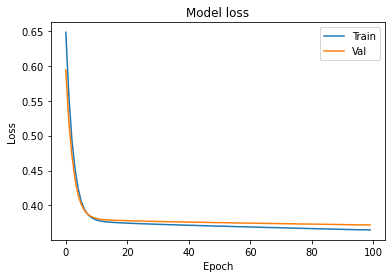

In [20]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

Visualizing Accuracy.

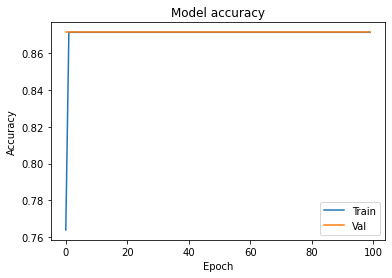

In [21]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

Evaluating test.

In [22]:
model.evaluate(X_test, Y_test)[1] #index 1 returns accuracy, index 0 returns loss

8/8 [==============================] - 0s 374us/step - loss: 0.4231 - accuracy: 0.8388


0.8388429880142212

The accuracy of predicting a delinquent is 88.84%. We can also try different techniques to improve the accuracy using the same variables and input values.

### CNN with Over-fitting and Regularization

In [23]:
model2 = Sequential([
    Dense(1000, activation='relu', input_shape=(5,)),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
h2 = model2.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, Y_val),callbacks=[tensorboardOf])

Epoch 1/100
36/36 [==============================] - 1s 20ms/step - loss: 0.3930 - accuracy: 0.8696 - val_loss: 0.3616 - val_accuracy: 0.8714
Epoch 2/100
36/36 [==============================] - 0s 11ms/step - loss: 0.3684 - accuracy: 0.8722 - val_loss: 0.3464 - val_accuracy: 0.8714
Epoch 3/100
36/36 [==============================] - 0s 10ms/step - loss: 0.3365 - accuracy: 0.8749 - val_loss: 0.3365 - val_accuracy: 0.8714
Epoch 4/100
36/36 [==============================] - 0s 12ms/step - loss: 0.3303 - accuracy: 0.8749 - val_loss: 0.3240 - val_accuracy: 0.8714
Epoch 5/100
36/36 [==============================] - 0s 11ms/step - loss: 0.3311 - accuracy: 0.8749 - val_loss: 0.3173 - val_accuracy: 0.8714
Epoch 6/100
36/36 [==============================] - 0s 11ms/step - loss: 0.3190 - accuracy: 0.8749 - val_loss: 0.3120 - val_accuracy: 0.8714
Epoch 7/100
36/36 [==============================] - 0s 11ms/step - loss: 0.3271 - accuracy: 0.8749 - val_loss: 0.3143 - val_accuracy: 0.8714
Epoch 

36/36 [==============================] - 0s 12ms/step - loss: 0.2688 - accuracy: 0.8820 - val_loss: 0.2745 - val_accuracy: 0.8755
Epoch 57/100
36/36 [==============================] - 0s 12ms/step - loss: 0.2669 - accuracy: 0.8749 - val_loss: 0.2594 - val_accuracy: 0.8755
Epoch 58/100
36/36 [==============================] - 0s 12ms/step - loss: 0.2612 - accuracy: 0.8793 - val_loss: 0.2595 - val_accuracy: 0.8755
Epoch 59/100
36/36 [==============================] - 0s 11ms/step - loss: 0.2662 - accuracy: 0.8829 - val_loss: 0.2606 - val_accuracy: 0.8755
Epoch 60/100
36/36 [==============================] - 0s 11ms/step - loss: 0.2627 - accuracy: 0.8838 - val_loss: 0.2529 - val_accuracy: 0.8755
Epoch 61/100
36/36 [==============================] - 0s 12ms/step - loss: 0.2665 - accuracy: 0.8793 - val_loss: 0.2622 - val_accuracy: 0.8755
Epoch 62/100
36/36 [==============================] - 0s 11ms/step - loss: 0.2655 - accuracy: 0.8802 - val_loss: 0.2664 - val_accuracy: 0.8755
Epoch 63/100

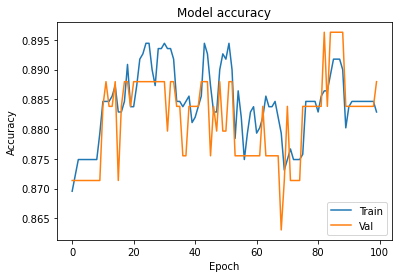

In [24]:
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [25]:
model2.evaluate(X_test, Y_test)[1]

8/8 [==============================] - 0s 2ms/step - loss: 0.3184 - accuracy: 0.8802


0.8801652789115906

### CNN  with Ridge Regression Regularization

In [26]:
model3 = Sequential([
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(5,)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)),
])

In [27]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
h3 = model3.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, Y_val),callbacks=[tensorboardRr])

Epoch 1/100
36/36 [==============================] - 1s 30ms/step - loss: 13.0548 - accuracy: 0.8642 - val_loss: 2.7987 - val_accuracy: 0.8714
Epoch 2/100
36/36 [==============================] - 1s 17ms/step - loss: 1.1420 - accuracy: 0.8713 - val_loss: 0.4871 - val_accuracy: 0.8714
Epoch 3/100
36/36 [==============================] - 1s 17ms/step - loss: 0.4527 - accuracy: 0.8713 - val_loss: 0.4337 - val_accuracy: 0.8714
Epoch 4/100
36/36 [==============================] - 1s 17ms/step - loss: 0.4280 - accuracy: 0.8713 - val_loss: 0.4236 - val_accuracy: 0.8714
Epoch 5/100
36/36 [==============================] - 1s 17ms/step - loss: 0.4218 - accuracy: 0.8713 - val_loss: 0.4215 - val_accuracy: 0.8714
Epoch 6/100
36/36 [==============================] - 1s 16ms/step - loss: 0.4205 - accuracy: 0.8713 - val_loss: 0.4176 - val_accuracy: 0.8714
Epoch 7/100
36/36 [==============================] - 1s 17ms/step - loss: 0.4164 - accuracy: 0.8713 - val_loss: 0.4165 - val_accuracy: 0.8714
Epoch

36/36 [==============================] - 1s 17ms/step - loss: 0.3888 - accuracy: 0.8713 - val_loss: 0.3871 - val_accuracy: 0.8714
Epoch 57/100
36/36 [==============================] - 1s 16ms/step - loss: 0.3894 - accuracy: 0.8713 - val_loss: 0.3870 - val_accuracy: 0.8714
Epoch 58/100
36/36 [==============================] - 1s 17ms/step - loss: 0.3870 - accuracy: 0.8713 - val_loss: 0.3872 - val_accuracy: 0.8714
Epoch 59/100
36/36 [==============================] - 1s 17ms/step - loss: 0.3890 - accuracy: 0.8713 - val_loss: 0.3880 - val_accuracy: 0.8714
Epoch 60/100
36/36 [==============================] - 1s 17ms/step - loss: 0.3900 - accuracy: 0.8713 - val_loss: 0.3874 - val_accuracy: 0.8714
Epoch 61/100
36/36 [==============================] - 1s 17ms/step - loss: 0.3894 - accuracy: 0.8713 - val_loss: 0.3869 - val_accuracy: 0.8714
Epoch 62/100
36/36 [==============================] - 1s 17ms/step - loss: 0.3863 - accuracy: 0.8713 - val_loss: 0.3869 - val_accuracy: 0.8714
Epoch 63/100

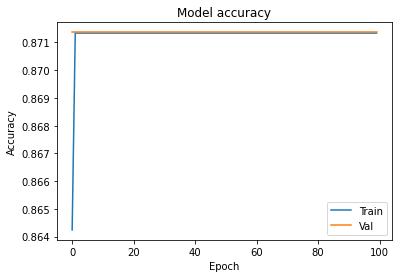

In [28]:
plt.plot(h3.history['accuracy'])
plt.plot(h3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [29]:
model3.evaluate(X_test, Y_test)[1]

8/8 [==============================] - 0s 4ms/step - loss: 0.4486 - accuracy: 0.8388


0.8388429880142212

# Conclusions

The accuracy of the 3 different techniques are the following:

*   85.12% for the CNN model
*   89.67% for the CNN with Over-fitting and Regularization model
*   85.12% for the CNN with Ridge Regression Regularization model

Notice that the most accurate model was the Over-Fitting and Regularization model. Altough the first and third model obtained the same accuracy percentage, the main difference between them is that the technique used in the third model prevents over-fitting issues.


#Summary

In this research, we coded a prediction model following these steps:

*   We prepared and processed the data
*   Built and Trained a Neural Network
*   Implemented functions to Visualize Loss and Accuracy
*   Added two regularization techniques to the Neural Network
*   Compared the accuracy of the models